<a href="https://colab.research.google.com/github/MusterMark8/ImagingInverseProblems/blob/main/TVreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Total Variation (TV) Image Deblurring

This colab is inspired by previously existing codes. See the course http://www-users.math.umn.edu/~jwcalder/5467Notes.pdf .



In [1]:
from google.colab import files

# Upload an image file
uploaded = files.upload()

# List the uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

# MAKE SURE YOUR IMAGE IS SQUARE OR REDEFINE THE FUNCTIONS TO SUPPORT RECTANGUALAR IMAGES


Let's load the cameraman image.

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('Coll.FondaxxxX-670x670.jpg')  #insert the filename of the imported image
assert img is not None, "file could not be read, check with os.path.exists()"




(670, 670, 3)


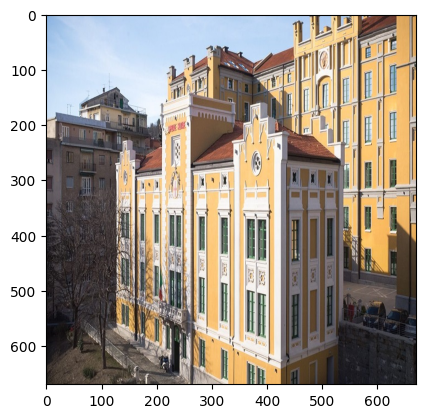

In [ ]:
print(img.shape)
#print(img)
plt.imshow(img)

Let's define a function to blur the image.

In [ ]:
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftshift
import numpy as np

def blur_filter(n,width=5):
    """Returns FFT of out of focus blur filter

    Args:
        n: dimensions of each side of the image
        width: Width of the out of focus filter

    Returns:
        G: Fourier transform of filter
    """

    x,y = np.mgrid[:n,:n]
    g = (x-n/2)**2 + (y-n/2)**2 < width**2
    g = g/np.sum(g)
    return fft2(fftshift(g)).real

def blur(f,G):
    """Blurs image f with filter G

    Args:
        f: image to blur
        G: Filter

    Returns:
        Blurred image
    """
    return ifft2(G*fft2(f)).real

Let's now blur an image and then deblur without any regularization. We see that the result is not acceptable, the noise screwed the inversion.

Text(0.5, 1.0, 'Direct deblurring')

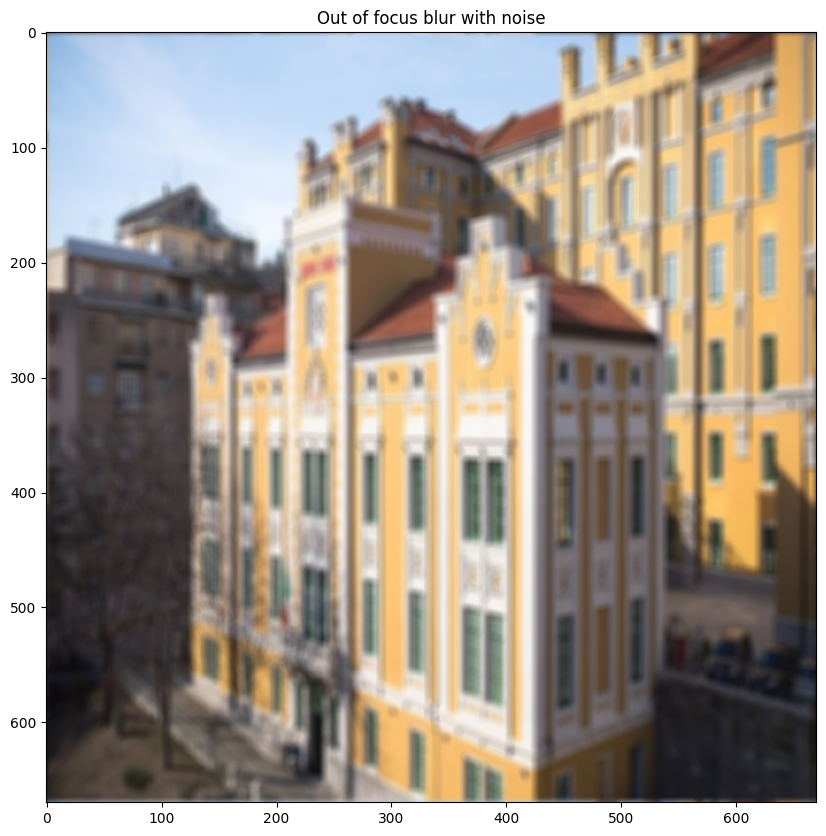

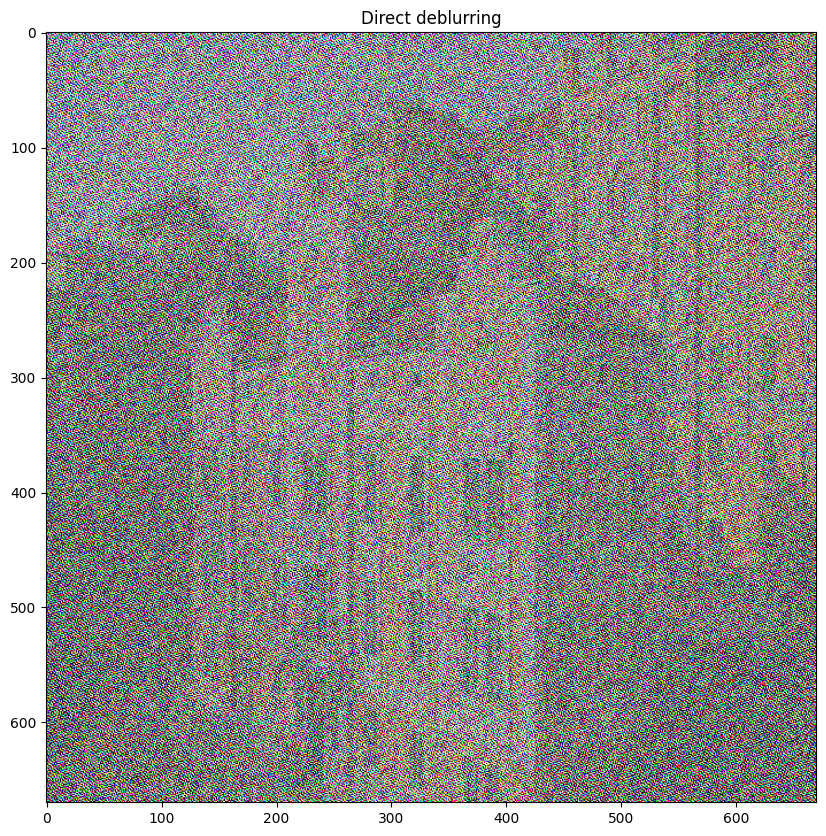

In [ ]:
#First get a blur filter
G = blur_filter(img.shape[0],width=5)


#Blur the https://colab.research.google.com/drive/1Cp2DcN3d7R_ypHXVnMQVRsFbU9ne8fXH?usp=sharingimage
#img_blurred = (blur(img[:,:,0],G)+blur(img[:,:,1],G)+blur(img[:,:,2],G))/3./255.  #B&W

img_blurred=np.zeros((670,670,3))
for i in range(3):
  img_blurred[:,:,i] = (blur(img[:,:,i],G))/255.
  #print(i)

#print(img_blurred)

#Add noise
sigma = 0.001   #Try sigma=0 first, and then try sigma > 0 to add noise
img_blurred = img_blurred + sigma*np.random.randn(img.shape[0],img.shape[1],img.shape[2])

#Show blurred and noisy image
plt.figure(figsize=(10,10))
plt.imshow(img_blurred) #,cmap='gray',vmin=0,vmax=1)
plt.title('Out of focus blur with noise')

img_deblurred=np.zeros((670,670,3))
#Deblur the image and imshow
for i in range(3):
  img_deblurred[:,:,i] = ifft2(fft2(img_blurred[:,:,i])/G).real
plt.figure(figsize=(10,10))
plt.imshow(img_deblurred) #,cmap='gray',vmin=0,vmax=1)
plt.title('Direct deblurring')


We define a Total Variation regularized deblurring function.


In [ ]:
import numpy as np

#Gradients and other functions for TV denoising
def fdiff_x(u):
    return np.vstack((u[1:,:],u[-2,:])) - u

def bdiff_x(u):
    return u - np.vstack((u[1,:],u[:-1,:]))

def fdiff_y(u):
    return np.hstack((u[:,1:],u[:,-2:-1])) - u

def bdiff_y(u):
    return u - np.hstack((u[:,1:2],u[:,:-1]))

def phi_prime(t,eps=1e-5):
    return t/np.sqrt(t**2 + eps**2)

def phi_const(eps=1e-5):
    return 1/eps

def tv_deblurring(f,G,lam,eps=1e-2,tol=1e-3,dt=None,maxiter=1e6):
    """Total Variation regularized image deblurring

    Args:
        f: Blurry image (numpy array)
        G: Blurring filter
        lam: TV regularization parameter
        eps: TV regularization
        tol: Tolerance for solving equation
        maxiter: Max number of iterations

    Returns:
        Deblurred image
    """
    n = len(f)
    u = f.copy()

    dt = 2/(1+4*2*phi_const(eps=eps)*lam)

    err = 1
    i = 0
    while i < maxiter and err > tol:
        #print(i)
        v = blur(blur(u,G) - f,G) - lam*(fdiff_x(phi_prime(bdiff_x(u),eps=eps)) + fdiff_y(phi_prime(bdiff_y(u),eps=eps)))
        u = u - dt*v
        err = np.max(np.absolute(v))
        i+=1

    print('TV deblurring took %d iterations'%i)
    return u


We now see how TV deblurring performs better.

TV deblurring took 226 iterations
TV deblurring took 193 iterations


TV deblurring took 242 iterations


Text(0.5, 1.0, 'Original Image')

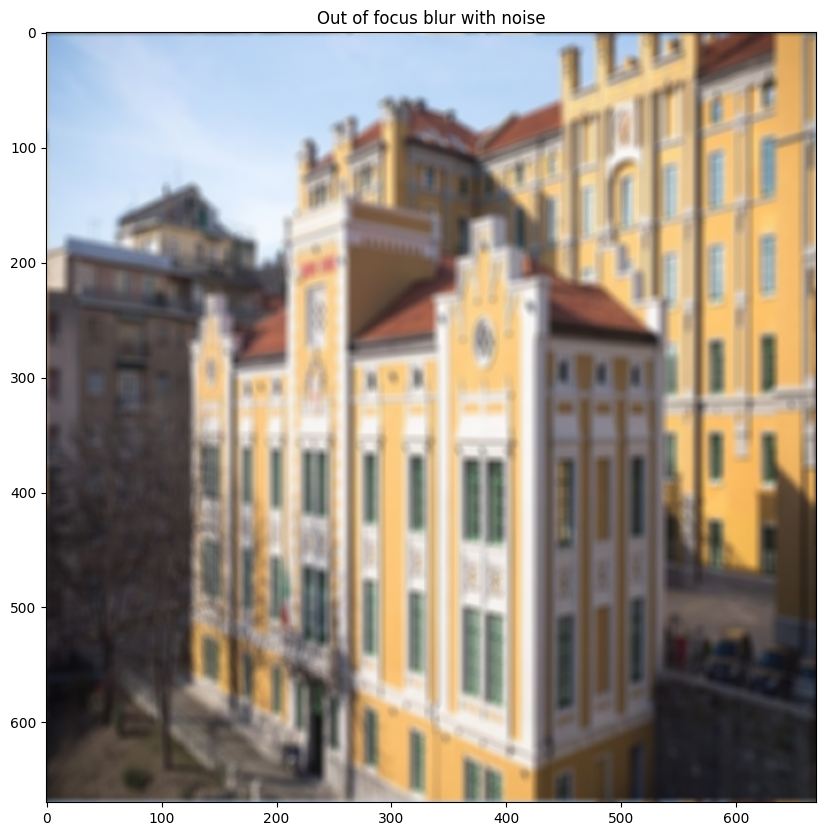

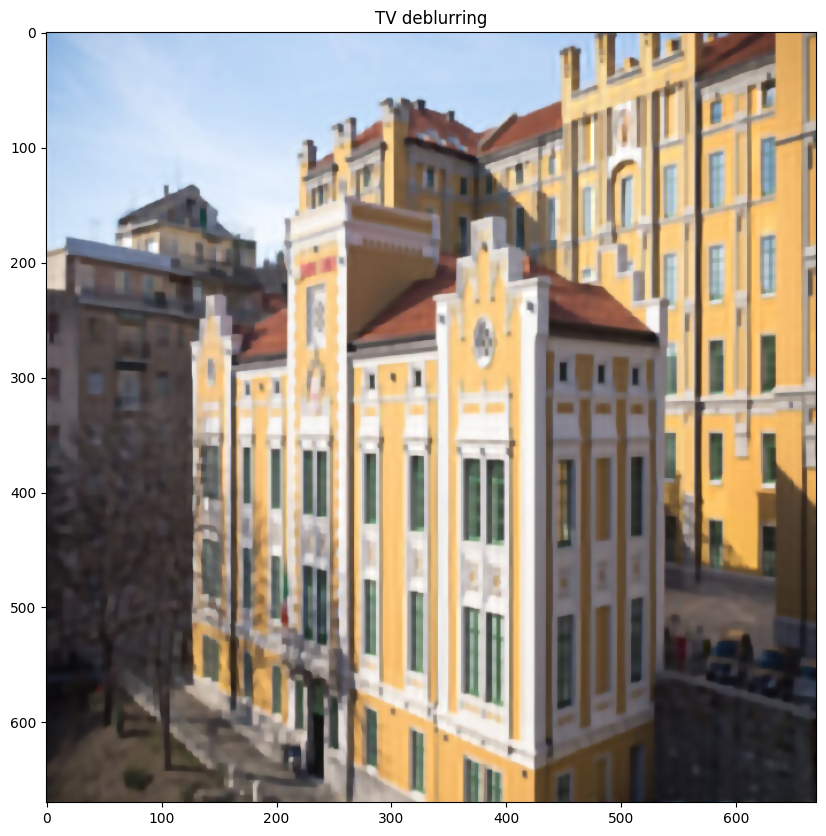

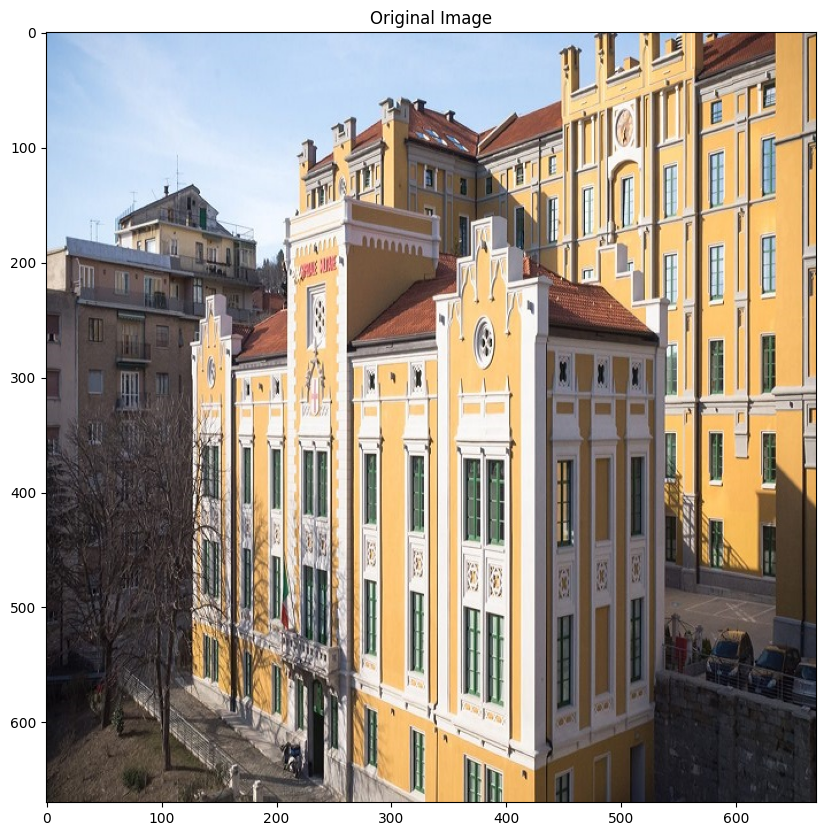

In [ ]:
#First get a blur filter
G = blur_filter(img.shape[0],width=5)

#Blur the image
#img_blurred = (blur(img[:,:,0],G)+blur(img[:,:,1],G)+blur(img[:,:,2],G))/3./255. #B&W

img_blurred=np.zeros((670,670,3))
for i in range(3):
  img_blurred[:,:,i] = (blur(img[:,:,i],G))/255.

#Add noise
sigma = 0.002
img_blurred = img_blurred + sigma*np.random.randn(img.shape[0],img.shape[1],img.shape[2])

#Show blurred and noisy image
plt.figure(figsize=(10,10))
plt.imshow(img_blurred) #,cmap='gray',vmin=0,vmax=1)
plt.title('Out of focus blur with noise')

tv_deblurred=np.zeros((670,670,3))
#TVDeblur the image and imshow
param=0.002        #parameter of TV deblurring
for i in range(3):
  tv_deblurred[:,:,i] = tv_deblurring(img_blurred[:,:,i],G,param)


plt.figure(figsize=(10,10))
plt.imshow(tv_deblurred) #,cmap='gray',vmin=0,vmax=1)
plt.title('TV deblurring')

plt.figure(figsize=(10,10))
plt.imshow(img) #,cmap='gray',vmin=0,vmax=1)
plt.title('Original Image')

Lastly we see the role of the rugularization parameter.

TV deblurring took 85 iterations
TV deblurring took 85 iterations


TV deblurring took 86 iterations
TV deblurring took 177 iterations
TV deblurring took 153 iterations


TV deblurring took 178 iterations
TV deblurring took 608 iterations
TV deblurring took 558 iterations


TV deblurring took 546 iterations


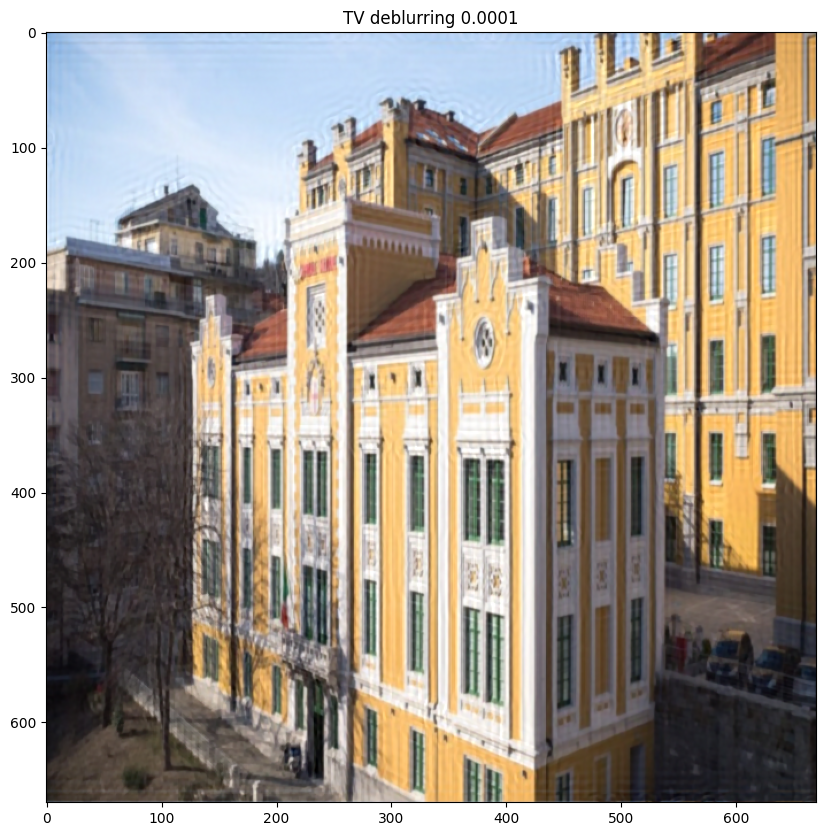

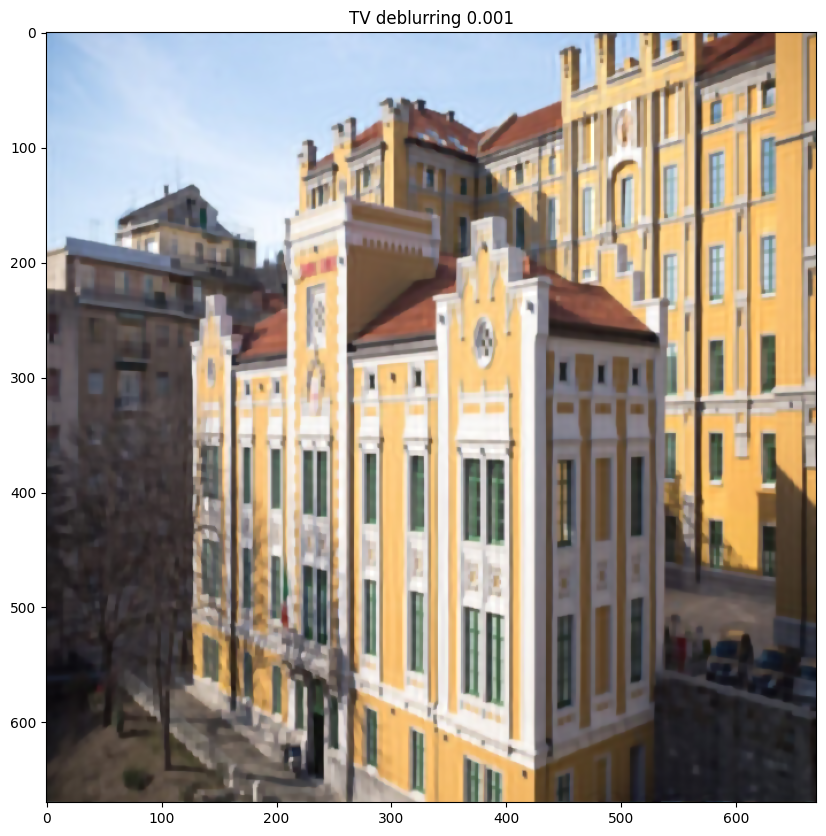

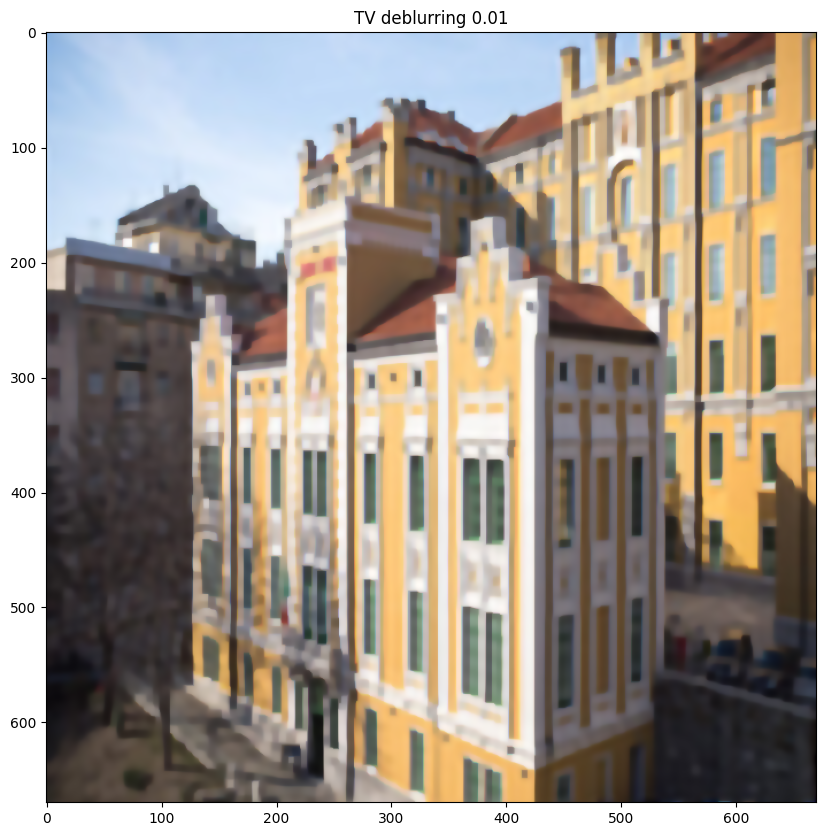

In [ ]:
#First get a blur filter
G = blur_filter(img.shape[0],width=5)

#Blur the image
#img_blurred = (blur(img[:,:,0],G)+blur(img[:,:,1],G)+blur(img[:,:,2],G))/3./255. #B&W

img_blurred=np.zeros((670,670,3))
for i in range(3):
  img_blurred[:,:,i] = (blur(img[:,:,i],G))/255.

#Add noise
sigma = 0.001
img_blurred = img_blurred + sigma*np.random.randn(img.shape[0],img.shape[1],img.shape[2])


tv_deblurred=np.zeros((670,670,3))
#TVDeblur the image and imshow
param=.0001 #parameter of TV deblurring
for j in range(3):
  for i in range(3):
    tv_deblurred[:,:,i] = tv_deblurring(img_blurred[:,:,i],G,param)


  plt.figure(figsize=(10,10))
  plt.imshow(tv_deblurred) #,cmap='gray',vmin=0,vmax=1)
  plt.title('TV deblurring {}'.format(param))
  param=param*10.

